In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/transformer-preprocessed-dataset/File5.csv


# Time Series Using LightGBM 

<a id="section-one"></a>
## 3.1.Import Library

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.width', None)

## Load Dataset

In [3]:

df = pd.read_csv("/kaggle/input/transformer-preprocessed-dataset/File5.csv", parse_dates=['Date_Time'])
df



,Date_Time,Sid,Did,Station_Pair,Year,Month,Is_Holiday,Holiday_Type,OneHourSlot,Weekday,Passenger_Count
0,2018-06-01 00:00:00,10.0,8.0,Aazadnagar-Thane Station West,2018,6,0,0,1,4,0.0
1,2018-06-01 01:00:00,10.0,8.0,Aazadnagar-Thane Station West,2018,6,0,0,2,4,0.0
2,2018-06-01 02:00:00,10.0,8.0,Aazadnagar-Thane Station West,2018,6,0,0,3,4,0.0
3,2018-06-01 03:00:00,10.0,8.0,Aazadnagar-Thane Station West,2018,6,0,0,4,4,0.0
4,2018-06-01 04:00:00,10.0,8.0,Aazadnagar-Thane Station West,2018,6,0,0,5,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1755211,2024-04-20 19:00:00,12.0,8.0,Voltas Gate-Thane Station West,2024,4,0,0,20,5,0.0
1755212,2024-04-20 20:00:00,12.0,8.0,Voltas Gate-Thane Station West,2024,4,0,0,21,5,0.0
1755213,2024-04-20 21:00:00,12.0,8.0,Voltas Gate-Thane Station West,2024,4,0,0,22,5,0.0
1755214,2024-04-20 22:00:00,12.0,8.0,Voltas Gate-Thane Station West,2024,4,0,0,23,5,0.0


<a id="section-two"></a>
# 3.2.Exploratory Data Analysis

In [4]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [5]:
check_df(df)

##################### Shape #####################
(1755216, 11)
##################### Types #####################
Date_Time          datetime64[ns]
Sid                       float64
Did                       float64
Station_Pair               object
Year                        int64
Month                       int64
Is_Holiday                  int64
Holiday_Type                int64
OneHourSlot                 int64
Weekday                     int64
Passenger_Count           float64
dtype: object
##################### Head #####################
            Date_Time   Sid  Did                   Station_Pair  Year  Month  \
0 2018-06-01 00:00:00  10.0  8.0  Aazadnagar-Thane Station West  2018      6   
1 2018-06-01 01:00:00  10.0  8.0  Aazadnagar-Thane Station West  2018      6   
2 2018-06-01 02:00:00  10.0  8.0  Aazadnagar-Thane Station West  2018      6   

   Is_Holiday  Holiday_Type  OneHourSlot  Weekday  Passenger_Count  
0           0             0            1        4          

<a id="section-three"></a>
## 3.3.Outlier Check  

Time for an outlier check!

For outlier detection, Ive used IQR method with Q1 as 0.05% and Q3 as 0.95%. I will compute the low limit and up limit with IQR method and check if the passenger count contain values above/below these limits. It will return boolean.



In [6]:
def outlier_thresholds(dataframe, col_name, q1_perc=0.05, q3_perc=0.95):
    """
    given dataframe, column name, q1_percentage and q3 percentage, function calculates low_limit and up_limit

    """
    quartile1 = dataframe[col_name].quantile(q1_perc)
    quartile3 = dataframe[col_name].quantile(q3_perc)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name, q1_perc=0.01, q3_perc=0.99):
    outlier_list = []
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1_perc=0.01, q3_perc=0.99)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True

    else:
        return False

In [7]:
check_outlier(df, 'Passenger_Count')

True

In [8]:
# check the df
df.head()

,Date_Time,Sid,Did,Station_Pair,Year,Month,Is_Holiday,Holiday_Type,OneHourSlot,Weekday,Passenger_Count
0,2018-06-01 00:00:00,10.0,8.0,Aazadnagar-Thane Station West,2018,6,0,0,1,4,0.0
1,2018-06-01 01:00:00,10.0,8.0,Aazadnagar-Thane Station West,2018,6,0,0,2,4,0.0
2,2018-06-01 02:00:00,10.0,8.0,Aazadnagar-Thane Station West,2018,6,0,0,3,4,0.0
3,2018-06-01 03:00:00,10.0,8.0,Aazadnagar-Thane Station West,2018,6,0,0,4,4,0.0
4,2018-06-01 04:00:00,10.0,8.0,Aazadnagar-Thane Station West,2018,6,0,0,5,4,0.0


In [9]:
print(f"total number of station-pairs: {df['Station_Pair'].nunique()}\n")
print(f"total number of items: {df['Passenger_Count'].nunique()}\n")
print(f"total number of items per each store: {df.groupby(['Station_Pair'])['Passenger_Count'].nunique()}")

total number of station-pairs: 34

total number of items: 794

total number of items per each store: Station_Pair
Aazadnagar-Thane Station West              2
Cadbury Company-Gavandbaug                 4
Cadbury Company-Incometax Office           1
Cadbury Company-Thane Station West         7
Civil/Court-Pawar Nagar                  182
Civil/Court-Thane Station West            19
Civil/Court-Voltas Gate                   72
Dongripada-Anandnagar Aagar                4
Dongripada-Majiwadanaka                    1
Incometax Office-Thane Station West        3
Khevra Circle-Anandnagar Aagar            11
Khevra Circle-Dongripada                   4
Majiwadanaka-Kolshet                       1
Majiwadanaka-Thane Station West            1
Manpada-Thane Station West                 1
Pawar Nagar-Anandnagar Aagar               7
Pawar Nagar-Cadbury Company                3
Pawar Nagar-Civil/Court                   46
Pawar Nagar-Dongripada                     5
Pawar Nagar-Incometax Office   

In [10]:
# before building an ML model, let's have a basic prediction by taking the mean values for each item on each store 

df.groupby(["Station_Pair", "Passenger_Count"]).agg({"Passenger_Count": ["sum", "mean", "median", "std"]})

Passenger_Count                \
                                                           sum   mean median   
Station_Pair                   Passenger_Count                                 
Aazadnagar-Thane Station West  0.0                         0.0    0.0    0.0   
                               1.0                         1.0    1.0    1.0   
Cadbury Company-Gavandbaug     0.0                         0.0    0.0    0.0   
                               1.0                         1.0    1.0    1.0   
                               2.0                         2.0    2.0    2.0   
...                                                        ...    ...    ...   
Voltas Gate-Thane Station West 238.0                     238.0  238.0  238.0   
                               248.0                     248.0  248.0  248.0   
                               250.0                     250.0  250.0  250.0   
                               256.0                     256.0  256.0  256.0   
                               267.0                     267.0  267.0  267.0   

                                                     
                                                std  
Station_Pair                   Passenger_Count       
Aazadnagar-Thane Station West  0.0              0.0  
                               1.0              NaN  
Cadbury Company-Gavandbaug     0.0              0.0  
                               1.0              NaN  
                               2.0              NaN  
...                                             ...  
Voltas Gate-Thane Station West 238.0            NaN  
                               248.0            NaN  
                               250.0            NaN  
                               256.0            NaN  
                               267.0            NaN  

[2425 rows x 4 columns]

### Considering only Top 5 Station Pairs

In [11]:
# Group by 'Station_Pair' and sum the 'Passenger_Count'
station_pair_counts = df.groupby('Station_Pair')['Passenger_Count'].sum().reset_index()

# Calculate total passenger count
total_passenger_count = station_pair_counts['Passenger_Count'].sum()

# Calculate percentage contribution for each station pair
station_pair_counts['Percentage'] = (station_pair_counts['Passenger_Count'] / total_passenger_count) * 100

# Sort  by 'Percentage' and 'Passenger_Count' in descending order
station_pair_counts = station_pair_counts.sort_values(by=['Percentage', 'Passenger_Count'], ascending=False)

print(station_pair_counts)

                             Station_Pair  Passenger_Count  Percentage
26         Thane Station West-Pawar Nagar       11058191.0   48.414227
28         Thane Station West-Voltas Gate        7339195.0   32.131969
4                 Civil/Court-Pawar Nagar        2348063.0   10.280131
25         Thane Station West-Civil/Court         666411.0    2.917636
6                 Civil/Court-Voltas Gate         614491.0    2.690323
22         Pawar Nagar-Thane Station West         340180.0    1.489353
32                Voltas Gate-Pawar Nagar         218123.0    0.954971
33         Voltas Gate-Thane Station West         187369.0    0.820326
17                Pawar Nagar-Civil/Court          44570.0    0.195133
5          Civil/Court-Thane Station West           8987.0    0.039346
30                Voltas Gate-Civil/Court           8006.0    0.035051
23                Pawar Nagar-Voltas Gate           3518.0    0.015402
10         Khevra Circle-Anandnagar Aagar           1669.0    0.007307
15    

In [12]:
top5 = station_pair_counts.loc[[26, 28, 4, 25, 6], :]
top5

,Station_Pair,Passenger_Count,Percentage
26,Thane Station West-Pawar Nagar,11058191.0,48.414227
28,Thane Station West-Voltas Gate,7339195.0,32.131969
4,Civil/Court-Pawar Nagar,2348063.0,10.280131
25,Thane Station West-Civil/Court,666411.0,2.917636
6,Civil/Court-Voltas Gate,614491.0,2.690323


In [13]:
station_pairs = ['Thane Station West-Pawar Nagar', 'Thane Station West-Voltas Gate', 'Civil/Court-Pawar Nagar', 'Thane Station West-Civil/Court', 'Civil/Court-Voltas Gate']
df = df[df['Station_Pair'].isin(station_pairs)]

In [14]:
df.set_index('Date_Time', drop=False)

,Date_Time,Sid,Did,Station_Pair,Year,Month,Is_Holiday,Holiday_Type,OneHourSlot,Weekday,Passenger_Count
Date_Time,,,,,,,,,,,
2018-06-01 00:00:00,2018-06-01 00:00:00,5.0,14.0,Civil/Court-Pawar Nagar,2018,6,0,0,1,4,0.0
2018-06-01 01:00:00,2018-06-01 01:00:00,5.0,14.0,Civil/Court-Pawar Nagar,2018,6,0,0,2,4,0.0
2018-06-01 02:00:00,2018-06-01 02:00:00,5.0,14.0,Civil/Court-Pawar Nagar,2018,6,0,0,3,4,0.0
2018-06-01 03:00:00,2018-06-01 03:00:00,5.0,14.0,Civil/Court-Pawar Nagar,2018,6,0,0,4,4,0.0
2018-06-01 04:00:00,2018-06-01 04:00:00,5.0,14.0,Civil/Court-Pawar Nagar,2018,6,0,0,5,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-04-20 19:00:00,2024-04-20 19:00:00,8.0,12.0,Thane Station West-Voltas Gate,2024,4,0,0,20,5,121.0
2024-04-20 20:00:00,2024-04-20 20:00:00,8.0,12.0,Thane Station West-Voltas Gate,2024,4,0,0,21,5,94.0
2024-04-20 21:00:00,2024-04-20 21:00:00,8.0,12.0,Thane Station West-Voltas Gate,2024,4,0,0,22,5,100.0


In [15]:
df_2023 = df[df['Year'] == 2023]
df_2023

,Date_Time,Sid,Did,Station_Pair,Year,Month,Is_Holiday,Holiday_Type,OneHourSlot,Weekday,Passenger_Count
246696,2023-01-01 00:00:00,5.0,14.0,Civil/Court-Pawar Nagar,2023,1,0,0,1,6,5.0
246697,2023-01-01 01:00:00,5.0,14.0,Civil/Court-Pawar Nagar,2023,1,0,0,2,6,0.0
246698,2023-01-01 02:00:00,5.0,14.0,Civil/Court-Pawar Nagar,2023,1,0,0,3,6,0.0
246699,2023-01-01 03:00:00,5.0,14.0,Civil/Court-Pawar Nagar,2023,1,0,0,4,6,0.0
246700,2023-01-01 04:00:00,5.0,14.0,Civil/Court-Pawar Nagar,2023,1,0,0,5,6,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1494427,2023-12-31 19:00:00,8.0,12.0,Thane Station West-Voltas Gate,2023,12,0,0,20,6,140.0
1494428,2023-12-31 20:00:00,8.0,12.0,Thane Station West-Voltas Gate,2023,12,0,0,21,6,100.0
1494429,2023-12-31 21:00:00,8.0,12.0,Thane Station West-Voltas Gate,2023,12,0,0,22,6,85.0
1494430,2023-12-31 22:00:00,8.0,12.0,Thane Station West-Voltas Gate,2023,12,0,0,23,6,71.0


<a id="section-four"></a>
# 3.4.Time Series Decomposition  




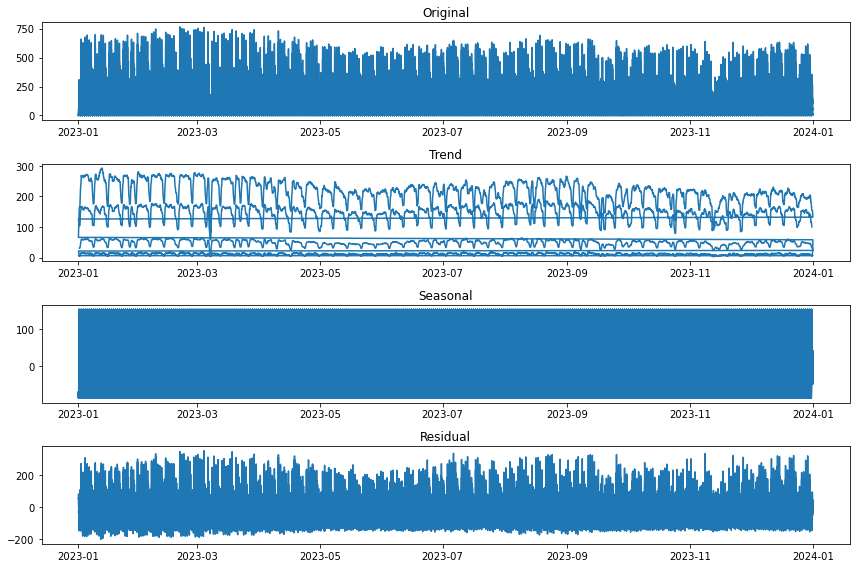

In [16]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming df_2023 is your DataFrame
df_2023 = df_2023.set_index('Date_Time')

# Perform seasonal decomposition
result = seasonal_decompose(df_2023['Passenger_Count'], model='additive', period=24)

# Plot the seasonal decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

ax1.plot(df_2023.index, df_2023['Passenger_Count'])
ax1.set_title('Original')

ax2.plot(result.trend)
ax2.set_title('Trend')

ax3.plot(result.seasonal)
ax3.set_title('Seasonal')

ax4.plot(result.resid)
ax4.set_title('Residual')

plt.tight_layout()
plt.show()

<a id="section-five"></a>
# 3.5.Feature Engineering



In [19]:
def create_date_features(df_2023):
    
    df_2023['day_of_month'] = df_2023.index.day
    df_2023['day_of_year'] = df_2023.index.dayofyear
    df_2023['week_of_year'] = df_2023.index.isocalendar().week
    
    df_2023['day_of_week'] = df_2023.index.dayofweek + 1
    df_2023["is_wknd"] = df_2023.index.weekday // 4
    df_2023['is_month_start'] = df_2023.index.is_month_start.astype(int)
    df_2023['is_month_end'] = df_2023.index.is_month_end.astype(int)
    return df_2023

df_2023 = create_date_features(df_2023)
df_2023.head()

,Sid,Did,Station_Pair,Year,Month,Is_Holiday,Holiday_Type,OneHourSlot,Weekday,Passenger_Count,day_of_month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end
Date_Time,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,5.0,14.0,Civil/Court-Pawar Nagar,2023,1,0,0,1,6,5.0,1,1,52,7,1,1,0
2023-01-01 01:00:00,5.0,14.0,Civil/Court-Pawar Nagar,2023,1,0,0,2,6,0.0,1,1,52,7,1,1,0
2023-01-01 02:00:00,5.0,14.0,Civil/Court-Pawar Nagar,2023,1,0,0,3,6,0.0,1,1,52,7,1,1,0
2023-01-01 03:00:00,5.0,14.0,Civil/Court-Pawar Nagar,2023,1,0,0,4,6,0.0,1,1,52,7,1,1,0
2023-01-01 04:00:00,5.0,14.0,Civil/Court-Pawar Nagar,2023,1,0,0,5,6,0.0,1,1,52,7,1,1,0


<a id="section-six"></a>
## 3.5.1.Random Noise

For small datasets like this one, in order to avoid overfitting, random noise can be added to the values. I will add Gaussian random noise which is normally distributed with a standard deviation of 1 and mean of 0.

In [20]:
def random_noise(dataframe):

    return np.random.normal(size=(len(dataframe),))

<a id="section-seven"></a>
## 3.5.2.Lag/Shifted Features 

Time Series theory states that, the value in time: t highly depends on the value in time: t-1. That is why I will be shifting all the sales values by 1 and adding noise.

In [21]:
# sort the values per station pairs, passenger counts and datetime so that values would be shifted equally

df_2023.sort_values(by=['Passenger_Count', 'Station_Pair', 'Date_Time'], axis=0, inplace=True)

In [22]:
# the feature name will be created dynamically with regards to the lag value for a given list of lags

def lag_features(dataframe, lags):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe['Passenger Count' + str(lag)] = dataframe.groupby(["Passenger_Count", "Date_Time"])['Passenger_Count'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

1. Lag 1: Passenger count at the previous hour (t-1)
1. Lag 2: Passenger count at two hours ago (t-2)
1. Lag 3: Passenger count at three hours ago (t-3)
1. Lag 24: Passenger count at the same hour on the previous day (t-24)
1. Lag 168: Passenger count at the same hour on the previous week (t-168)


1. Lag 1, 2, 3: to capture the immediate past hours and helping the model learn the short-term trends and patterns in passenger traffic.
1. Lag 24: represents the same hour on the previous day and helping the model learn the daily seasonality patterns. For example, the passenger count at 8 AM on a Monday may be influenced by the count at 8 AM on the previous Monday.
1. Lag 168: represents the same hour on the previous week and can help the model learn the weekly seasonality patterns. For example, the passenger count at 8 AM on a Monday may be influenced by the count at 8 AM on the previous Monday.

In [23]:
df_2023 = lag_features(df_2023, [1, 2, 3, 24, 168])

In [24]:
df_2023.head(3)

,Sid,Did,Station_Pair,Year,Month,Is_Holiday,Holiday_Type,OneHourSlot,Weekday,Passenger_Count,...,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,Passenger Count1,Passenger Count2,Passenger Count3,Passenger Count24,Passenger Count168
Date_Time,,,,,,,,,,,,,,,,,,,,,
2023-01-01 01:00:00,5.0,14.0,Civil/Court-Pawar Nagar,2023,1,0,0,2,6,0.0,...,52,7,1,1,0,NaN,NaN,NaN,NaN,NaN
2023-01-01 02:00:00,5.0,14.0,Civil/Court-Pawar Nagar,2023,1,0,0,3,6,0.0,...,52,7,1,1,0,NaN,NaN,NaN,NaN,NaN
2023-01-01 03:00:00,5.0,14.0,Civil/Court-Pawar Nagar,2023,1,0,0,4,6,0.0,...,52,7,1,1,0,NaN,NaN,NaN,NaN,NaN


In [25]:
df_2023.columns.to_list()

['Sid',
 'Did',
 'Station_Pair',
 'Year',
 'Month',
 'Is_Holiday',
 'Holiday_Type',
 'OneHourSlot',
 'Weekday',
 'Passenger_Count',
 'day_of_month',
 'day_of_year',
 'week_of_year',
 'day_of_week',
 'is_wknd',
 'is_month_start',
 'is_month_end',
 'Passenger Count1',
 'Passenger Count2',
 'Passenger Count3',
 'Passenger Count24',
 'Passenger Count168']

In [26]:
print(df_2023.dtypes)

Sid                   float64
Did                   float64
Station_Pair           object
Year                    int64
Month                   int64
Is_Holiday              int64
Holiday_Type            int64
OneHourSlot             int64
Weekday                 int64
Passenger_Count       float64
day_of_month            int64
day_of_year             int64
week_of_year           UInt32
day_of_week             int64
is_wknd                 int64
is_month_start          int64
is_month_end            int64
Passenger Count1      float64
Passenger Count2      float64
Passenger Count3      float64
Passenger Count24     float64
Passenger Count168    float64
dtype: object


In [27]:
df_2023['week_of_year']=df_2023['week_of_year'].astype('int64')

In [28]:
df_2023['week_of_year'].dtype

dtype('int64')

ive peformed OHE on the Station-Pair columns 

In [30]:
df_2023 = pd.get_dummies(df_2023, columns=['Station_Pair'], prefix='station_pair')

In [31]:
df_2023.columns.to_list()

['Sid',
 'Did',
 'Year',
 'Month',
 'Is_Holiday',
 'Holiday_Type',
 'OneHourSlot',
 'Weekday',
 'Passenger_Count',
 'day_of_month',
 'day_of_year',
 'week_of_year',
 'day_of_week',
 'is_wknd',
 'is_month_start',
 'is_month_end',
 'Passenger Count1',
 'Passenger Count2',
 'Passenger Count3',
 'Passenger Count24',
 'Passenger Count168',
 'station_pair_Civil/Court-Pawar Nagar',
 'station_pair_Civil/Court-Voltas Gate',
 'station_pair_Thane Station West-Civil/Court',
 'station_pair_Thane Station West-Pawar Nagar',
 'station_pair_Thane Station West-Voltas Gate']

<a id="section-eight"></a>
## 3.5.3.Rolling Mean / Moving Average  

In order to find out possible seasonalities, I will be creating moving averagesfor specified time intervals. This function takes the number of time given as window parameter and takes the average of the values, but one of the values is the value on this specific observation. In order to eliminate today's affect on moving average values, I will take 1 shift and use this function

In [33]:
def roll_mean_features(dataframe, windows):
    dataframe = dataframe.copy()
    for window in windows:
        dataframe['Passenger Count Roll Mean' + str(window)] = dataframe.groupby(["Passenger_Count", "Date_Time"])['Passenger_Count']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe



* Window size of 24:
    * A window size of 24 corresponds to the rolling mean of passenger counts over the past 24 hours.
    * This captures the daily seasonality patterns in the data, as it considers the passenger counts from the same hour on the previous days.
    
    
* Window size of 168:
    * A window size of 168 corresponds to the rolling mean of passenger counts over the past 7 days (1 week).
    * This captures the weekly seasonality patterns in the data, as it considers the passenger counts from the same hour on the previous weeks.
    



In [41]:
df_2023 = roll_mean_features(df_2023, [24, 168])
df_2023.head()

,Sid,Did,Year,Month,Is_Holiday,Holiday_Type,OneHourSlot,Weekday,Passenger_Count,day_of_month,...,Passenger_Count_ewm_alpha_07_lag_1,Passenger_Count_ewm_alpha_07_lag_2,Passenger_Count_ewm_alpha_07_lag_3,Passenger_Count_ewm_alpha_07_lag_24,Passenger_Count_ewm_alpha_07_lag_168,Passenger_Count_ewm_alpha_05_lag_1,Passenger_Count_ewm_alpha_05_lag_2,Passenger_Count_ewm_alpha_05_lag_3,Passenger_Count_ewm_alpha_05_lag_24,Passenger_Count_ewm_alpha_05_lag_168
Date_Time,,,,,,,,,,,,,,,,,,,,,
2023-01-01 01:00:00,5.0,14.0,2023,1,0,0,2,6,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 02:00:00,5.0,14.0,2023,1,0,0,3,6,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 03:00:00,5.0,14.0,2023,1,0,0,4,6,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 04:00:00,5.0,14.0,2023,1,0,0,5,6,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 01:00:00,5.0,14.0,2023,1,0,0,2,0,0.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The values for the newly derived lag and rolling mean features will be NaN for most of the train part of the dataframe. This is normal as we are trying to find patterns in order to be able to predict the values in test dataset.

<a id="section-nine"></a>
## 3.5.4.Exponentially Weighted Mean Features  

The value in time t highly depends on the value in time t-1, so in order to have a better prediction, while computing the average value, the values should not be equally weighted.

In [38]:
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['Passenger_Count_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["Passenger_Count", "Date_Time"])['Passenger_Count']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In this function, values will be shifted by the given lags (number of days to be used for calculation) and the values will be weighted (using the alpha value) and the mean weighted value is obtained.
Alpha is a parameter that is between 0 and 1, when close to 1 the near past will be weighted more and oppositely when close to 0 the far past will be weighted more.

In [39]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [1, 2, 3, 24, 168]

* alpha=0.95 will give the highest weight to the most recent observation and a slower decay, suitable for capturing short-term trends.
* alpha=0.9 will also give more weight to recent observations but with a slightly faster decay.
* alpha=0.8 and alpha=0.7 will have a moderate decay rate, suitable for capturing medium-term trends.
* alpha=0.5 will have the fastest decay rate, giving equal weight to all observations within the specified lag window.

In [40]:
df_2023 = ewm_features(df_2023, alphas, lags)
df_2023.tail()

,Sid,Did,Year,Month,Is_Holiday,Holiday_Type,OneHourSlot,Weekday,Passenger_Count,day_of_month,...,Passenger_Count_ewm_alpha_07_lag_1,Passenger_Count_ewm_alpha_07_lag_2,Passenger_Count_ewm_alpha_07_lag_3,Passenger_Count_ewm_alpha_07_lag_24,Passenger_Count_ewm_alpha_07_lag_168,Passenger_Count_ewm_alpha_05_lag_1,Passenger_Count_ewm_alpha_05_lag_2,Passenger_Count_ewm_alpha_05_lag_3,Passenger_Count_ewm_alpha_05_lag_24,Passenger_Count_ewm_alpha_05_lag_168
Date_Time,,,,,,,,,,,,,,,,,,,,,
2023-02-22 09:00:00,8.0,14.0,2023,2,0,0,10,2,747.0,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-21 09:00:00,8.0,14.0,2023,2,0,0,10,1,749.0,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-01 09:00:00,8.0,14.0,2023,3,0,0,10,2,752.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-04 09:00:00,8.0,14.0,2023,3,0,0,10,5,761.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-20 09:00:00,8.0,14.0,2023,2,0,0,10,0,765.0,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* By using these lag values and alpha values, you will create the following EWM features:
* Passenger_Count_ewm_alpha_095_lag_1: EWM of passenger counts with alpha=0.95 and lag=1.
* Passenger_Count_ewm_alpha_095_lag_2: EWM of passenger counts with alpha=0.95 and lag=2.
* Passenger_Count_ewm_alpha_095_lag_3: EWM of passenger counts with alpha=0.95 and lag=3.
* Passenger_Count_ewm_alpha_095_lag_24: EWM of passenger counts with alpha=0.95 and lag=24.
* Passenger_Count_ewm_alpha_095_lag_168: EWM of passenger counts with alpha=0.95 and lag=168.
* Passenger_Count_ewm_alpha_090_lag_1: EWM of passenger counts with alpha=0.9 and lag=1.
* ...
* Passenger_Count_ewm_alpha_050_lag_168: EWM of passenger counts with alpha=0.5 and lag=168.

These EWM features, along with the lag features and rolling mean features, are going to be used as input variables our time series forecasting models, potentially improving their ability to capture short-term trends, daily seasonality, weekly seasonality, and the recent behavior of the passenger count data.

In [ ]:
# Convert 'Date_Time' column to datetime type
df_2023['Date_Time'] = pd.to_datetime(df_2023['Date_Time'])

# Reset the index to create a separate 'Date_Time' column
df_2023 = df_2023.reset_index()

# Specify the aggregation function in the pivot operation
df_2023_pivot = df_2023.pivot_table(index='Date_Time', values='Passenger_Count', aggfunc='mean')

# Display the resulting pivot table
print(df_2023_pivot)

<a id="section-ten"></a>
## 3.6.One-Hot Encoding

I won't be using features such as "day_of_year" for one hot encoding, it would derive 365 features which won't be helpful for the model.

In [ ]:
df_2023.head(3)

In [ ]:
df_2023 = pd.get_dummies(df_2023, columns=['Station_Pair', 'Passenger_Count', 'Month'])

## Taking Log Values of Sales  

In regression problems using gradient descent optimisation, when the target value is higher, the number of iterations would decrease and so the computation time. In order to eliminate this problem, I will be taking the logaritmic values of the target value. 

In [ ]:
df['Passenger_Count'] = np.log1p(df_2023["Passenger_Count"].values)
df['Passenger_Count'].head() 

<a id="section-eleven"></a>
## 3.7.Custom Cost Function 

I will define a custom cost function which is based on SMAPE which reverses the log values and calculates the SMAPE.

In [ ]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

**SMAPE**:  

Symmetric mean absolute percentage error (SMAPE or sMAPE) is an accuracy measure based on percentage (or relative) errors. Errors with higher values will be adjusted by diving it to the sum of the forecast and actual value's average.



<a id="section-twelve"></a>
##  3.8.Train-Validation Split

Validation will be the exact same time period as test, but the year before. 

In [ ]:
df_2023['Date_Time'] = pd.to_datetime(df_2023['Date_Time'])

In [ ]:
# Training Set: January 1, 2023, to February 28, 2023
train = df_2023.loc[(df_2023["Date_Time"] >= "2023-01-01") & (df_2023["Date_Time"] <= "2023-02-28"), :]
train["Date_Time"].min(), train["Date_Time"].max()

In [ ]:
print(train['Passenger Count91'].dtype)

In [ ]:
# Testing Set: March 1, 2023, to March 7, 2023
val = df_2023.loc[(df_2023["Date_Time"] >= "2023-03-01") & (df_2023["Date_Time"] <= "2023-03-07"), :]

In [ ]:
# columns with no useful information or with information that is already derived will be dropped.

cols = [col for col in train.columns if col not in ['Date_Time', 'Month', "Passenger_Count", "Year", "Station_Pair"]]

In [ ]:
# Convert 'week_of_year' column to int32
train['week_of_year'] = train['week_of_year'].astype('int32')
val['week_of_year'] = val['week_of_year'].astype('int32')

In [ ]:
train['week_of_year'] , val['week_of_year']

In [ ]:
Y_train = train['Date_Time']
X_train = train[cols]

Y_val = val['Date_Time']
X_val = val[cols]

If the model begins to memorize the train dataset instead of learning it, the error will get lower but the model won't be able to have a good prediction of the validation set (because it didn't learn the patterns) so the error in validation will begin to increase.

In the below graphic, as variance increase, the errors in both train and dataset decrease until they reach to a certain point where the test errors no longer decrease but train errors are still decreasing. This is the point where overfitting begins. This is the point where the iteration process should be interrupted. This will be handled by a special hyperparameter within LightGBM.

early_stopping_rounds wil be given as a hyperparameter. In the specified time intervals, the iteration will be paused and the l1 and SMAPE of train and validation set will be calculated, at the point where the validation error will begin to increase while train error is still decreasing, the iteration process will be interrupted.

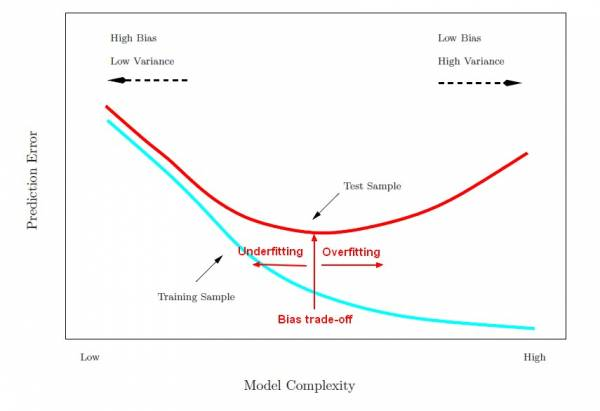

<a id="section-thirteen"></a>
## 3.9.Base Model

In [ ]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 15000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [ ]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [ ]:
# lgbtrain and lgbval's datatype is LightGBM Dataset

type(lgbtrain)

In [ ]:
lgbtrain = lgb.Dataset(data=X_train, label=train['Passenger_Count'], feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=val['Passenger_Count'], reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=200)

In [ ]:
# ticket count values in train dataset will be predicted, these are the log values

y_pred_val = model.predict(X_val)

In [ ]:
# log values are reversed and the predicted ticket count values are revealed. 

smape(np.expm1(y_pred_val), np.expm1(Y_val))

**Feature Importances**:

These will be calculated based on split and gain values, that is how often they have been used for splitting the values and the gain of entropy.

In [ ]:
def plot_lgb_importances(model,plot=True,num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    print(feat_imp.head(num))

In [ ]:
plot_lgb_importances(model,30)

In [ ]:
# this one is the built-in plot function of LightGBM library

lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()

<a id="section-fourteen"></a>
## 3.10.Final Model 

In [ ]:
# train and validation values are concatenated 

train = df_2023.loc[~df_2023.tickets.isna()]
Y_train = train['Passenger_Count']
X_train = train[cols]

test = df_2023.loc[df_2023.tickets.isna()]
X_test = test[cols]

In [ ]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

In [ ]:
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

<a id="section-fifteen"></a>
## 3.11.Submit Prediction 

In [ ]:
submission_df = test.loc[:, ['Date_Time', 'Passenger_Count']]
submission_df['Passenger_Count'] = np.expm1(test_preds)
submission_df['Date_Time'] = submission_df.id.astype(int)
submission_df.to_csv('submission.csv', index=False)